History matching using oscilator function

In [2]:
# Simple plotting of forward-model with a single response and parameters
from matplotlib import pyplot as plt


def plot_result(
    A, response_x_axis, trans_func=lambda x: x, priors=[], show_params=False
):
    responses = forward_model(A, priors, response_x_axis)
    plt.rcParams["figure.figsize"] = [15, 4]
    figures = 1 + len(A) if show_params else 1
    fig, axs = plt.subplots(1, figures)

    if show_params:
        axs[0].plot(response_x_axis, responses)
        for i, param in enumerate(A):
            A_trans = np.array([trans_func(v, *priors[i]) for v in param])
            axs[i + 1].hist(A_trans, bins=10)
    else:
        axs.plot(response_x_axis, responses)
    plt.show()

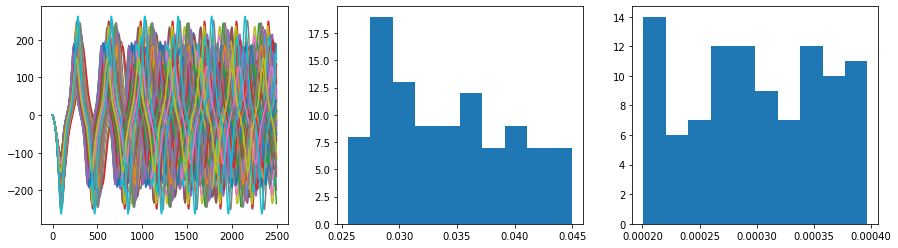

In [7]:
# Oscilator example
import numpy as np
from math import sqrt
from scipy.special import erf

observations = np.array(
    [
        [-1.423825, 1.000000],
        [-69.844756, 1.433117],
        [-161.372468, 3.172211],
        [-35.337207, 1.000000],
        [22.052601, 1.000000],
        [134.110882, 2.722560],
        [94.042261, 1.933744],
        [7.968471, 1.000000],
        [-59.026801, 1.189123],
        [-172.182170, 3.314200],
        [-41.489163, 1.000000],
        [16.814212, 1.000000],
        [118.654072, 2.409679],
        [114.423954, 2.247918],
        [12.416918, 1.000000],
        [-48.791008, 1.000000],
        [-164.566115, 3.344081],
        [-55.214065, 1.077207],
        [10.663810, 1.000000],
        [107.460193, 2.090707],
        [131.735466, 2.566827],
        [18.577686, 1.000000],
        [-38.452261, 1.000000],
        [-168.125616, 3.256886],
        [-65.512070, 1.306109],
        [5.117396, 1.000000],
        [86.849212, 1.784949],
        [143.113540, 2.866955],
        [27.215400, 1.000000],
        [-28.534937, 1.000000],
        [-150.957614, 3.066833],
        [-76.952587, 1.564988],
        [-1.553897, 1.000000],
        [73.362294, 1.503615],
        [151.480714, 3.117676],
        [33.463376, 1.000000],
        [-23.173303, 1.000000],
        [-141.945597, 2.801995],
        [-94.900341, 1.852485],
        [-5.620242, 1.000000],
        [62.969155, 1.251551],
        [163.894419, 3.286487],
        [42.643064, 1.000000],
        [-17.562715, 1.000000],
        [-124.921084, 2.495121],
        [-110.521190, 2.162494],
        [-11.222513, 1.000000],
        [52.852078, 1.029310],
        [167.590139, 3.347709],
        [51.112860, 1.020809],
    ]
)
observation_x_axis = [
    0,
    50,
    100,
    150,
    200,
    250,
    300,
    350,
    400,
    450,
    500,
    550,
    600,
    650,
    700,
    750,
    800,
    850,
    900,
    950,
    1000,
    1050,
    1100,
    1150,
    1200,
    1250,
    1300,
    1350,
    1400,
    1450,
    1500,
    1550,
    1600,
    1650,
    1700,
    1750,
    1800,
    1850,
    1900,
    1950,
    2000,
    2050,
    2100,
    2150,
    2200,
    2250,
    2300,
    2350,
    2400,
    2450,
]


def _evaluate(coeffs, K):

    x = np.zeros(K)
    x[0] = 0
    x[1] = 1

    # Looping from 2 because we have initial conditions at k=0 and k=1.
    for k in range(2, K - 1):
        M = np.array(
            [[2 + coeffs["omega"] ** 2 - coeffs["lmbda"] ** 2 * x[k] ** 2, -1], [1, 0]]
        )
        u = np.array([x[k], x[k - 1]])
        u = M @ u
        x[k + 1] = u[0]
        x[k] = u[1]

    return x


def uniform(x, min_x, max_x):
    y = 0.5 * (1 + erf(x / sqrt(2.0)))
    return y * (max_x - min_x) + min_x


def no_trans(x):
    y = 0.5 * (1 + erf(x / sqrt(2.0)))
    return y * (max_x - min_x) + min_x


def forward_model(A, prior, response_x_axis):
    responses = []
    for [omega, lmbda] in A.T:
        r = _evaluate(
            {"omega": uniform(omega, *prior[0]), "lmbda": uniform(lmbda, *prior[1])},
            len(response_x_axis),
        )
        responses.append(r)
    return np.array(responses).T


observation_values = observations[:, 0]
observation_errors = observations[:, 1]

response_x_axis = range(2500)
realizations = 100

A = np.asfortranarray(np.random.normal(0, 1, size=(2, realizations)))

priors = [(2.5e-2, 4.5e-2), (2.0e-4, 4.0e-4)]
# priors = [(), ()]
plot_result(A, response_x_axis, uniform, priors, True)

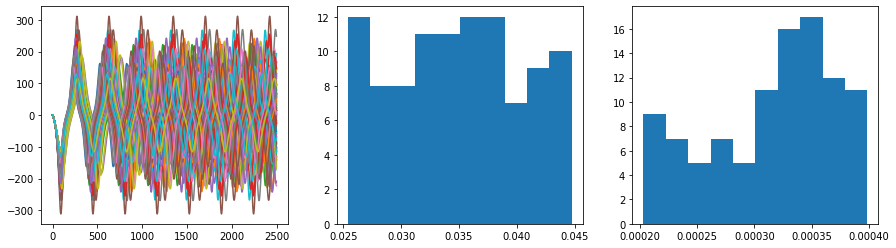

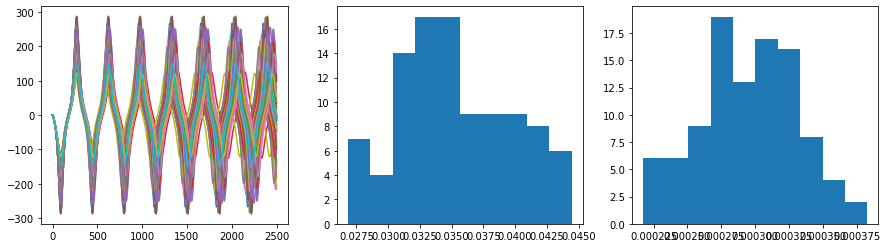

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from ert.analysis import ies


def ensemble_smoother():
    plot_result(A, response_x_axis, uniform, priors, True)
    responses_before = forward_model(A, priors, response_x_axis)
    S = responses_before[observation_x_axis]
    noise = np.random.rand(*S.shape)
    E = ies.make_E(observation_errors, noise)
    R = np.identity(len(observation_errors))
    D = ies.make_D(observation_values, E, S)
    D = (D.T / observation_errors).T
    E = (E.T / observation_errors).T
    S = (S.T / observation_errors).T

    X = ies.make_X(S, R, E, D)
    new_A = A @ X

    plot_result(new_A, response_x_axis, uniform, priors, True)


ensemble_smoother()

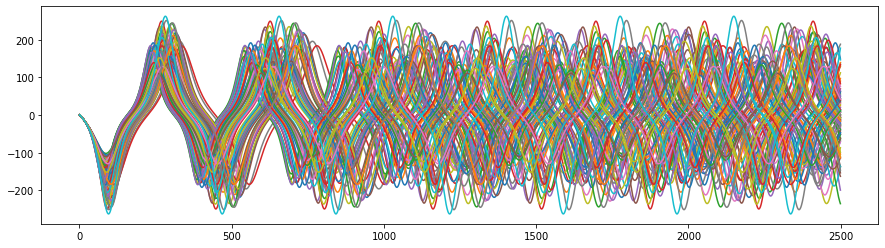

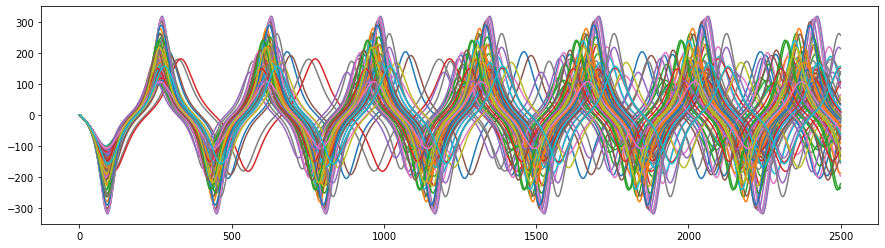

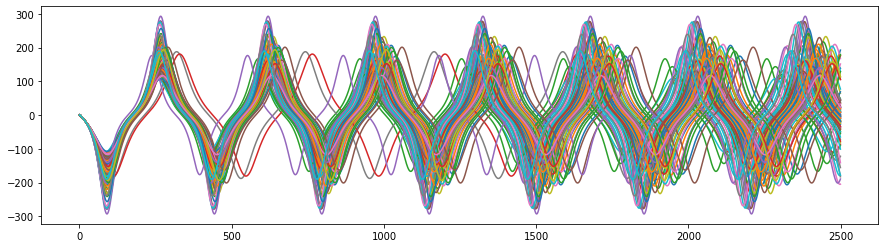

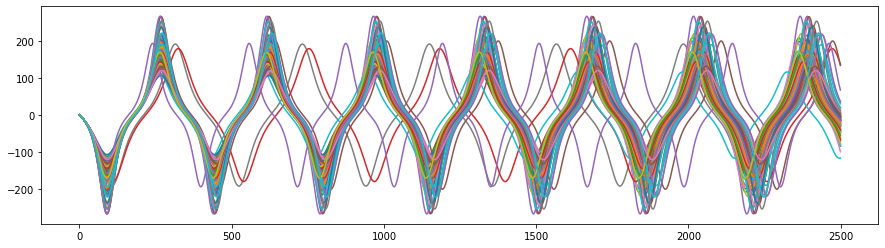

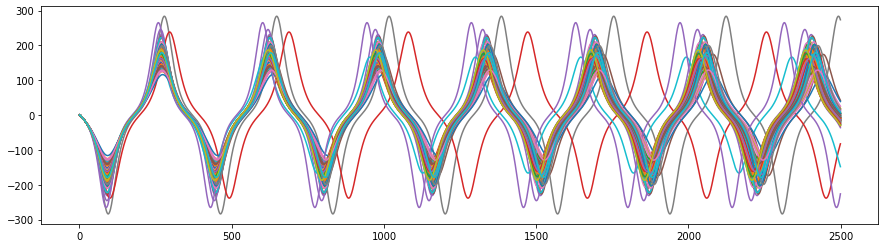

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from ert.analysis import ies


def iterative_smoother():

    iterations = 4
    obs_mask = [True for _ in observation_values]
    ens_mask = [True for _ in range(realizations)]
    module_data = ies.ModuleData(realizations)
    module_config = ies.Config(True)

    for i in range(iterations):
        plot_result(A, response_x_axis, uniform, priors, False)
        responses_before = forward_model(A, priors, response_x_axis)
        S = responses_before[observation_x_axis]
        noise = np.random.rand(*S.shape)
        E = ies.make_E(observation_errors, noise)
        R = np.identity(len(observation_errors))
        D = ies.make_D(observation_values, E, S)
        D = (D.T / observation_errors).T
        E = (E.T / observation_errors).T
        S = (S.T / observation_errors).T

        ies.init_update(module_data, ens_mask, obs_mask)
        iteration_nr = module_data.inc_iteration_nr()
        step_length = module_config.step_length(iteration_nr)
        ies.update_A(
            module_data,
            A,
            S,
            R,
            E,
            D,
            use_aa_projection=True,
            step_length=step_length,
        )

    plot_result(A, response_x_axis, uniform, priors, False)


iterative_smoother()